In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import tensorflow as tf
from keras import metrics, losses, optimizers
from keras.models import Model, Sequential
from keras.layers import (
    Dense,
    Input,
    Dropout,
    Flatten
)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

from scipy import signal
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Multi-Label Classification Example

This example demonstrates a simple multi-lablel classification problem where we wish to identify an event with an ADXL1002 accelerometer plugged into the CN0540 platform.

The objective here is quite simple, the ADXL1002 has been mounted to a standard floor standing tower fan and the speed setting of the fan wants to be determined. The problem might seem slightly contrived but similar scenarios in the field can exist when performing anomaly detection, and it is desirable to understand modes of operation.

Below is a picture of the Honeywell fan used for this experiment, and the CN0532 can be seem mounted in the second picture. Ideally the sensor would be mounted with bolts for maximal energy transfer to the sensor but painters tape is reasonable for the demo here, and does not require the fan to be taken apart.

![Honeywell fan]("img/fan1.png")

![Honeywell fan and CN0532]("img/fan2.png")

The central button on the control panel sets the speed of the internal fans and this is what needs to be identified by measuring the vibration of the unit in each mode.


### Data Collection and Import

The first step in any machine learning application is to collect the necessary data to train and test our system from. This was done by using the script [collect_data.py](https://github.com/analogdevicesinc/pyadi-iio/blob/cn0540/examples/cn0540/collect_data.py) co-located with this example. For convenience, this data is provided with the example in three files representing different modes.
- [Sleep: mode1.csv](https://github.com/analogdevicesinc/pyadi-iio/blob/cn0540/examples/cn0540/mode1.csv)
- [General: mode2.csv](https://github.com/analogdevicesinc/pyadi-iio/blob/cn0540/examples/cn0540/mode2.csv)
- [Allergen: mode3.csv](https://github.com/analogdevicesinc/pyadi-iio/blob/cn0540/examples/cn0540/mode3.csv)

Let us first load these in and examine the data.

In [2]:
def readfile(filename, label):
    data = np.loadtxt(filename, delimiter="\t")
    x = data
    y = label * np.ones(data.shape[0])
    return x, y.astype(int)

labels = ['Sleep', 'General', 'Allergen']
mode2_x, mode2_y = readfile("mode2.csv", 0)
mode3_x, mode3_y = readfile("mode3.csv", 1)
mode4_x, mode4_y = readfile("mode4.csv", 2)
modes_x = [mode2_x, mode3_x, mode4_x]

# Merge sample sets
x = np.concatenate((mode2_x, mode3_x, mode4_x), axis=0)
y = np.concatenate((mode2_y, mode3_y, mode4_y), axis=0)

print(mode2_x.shape)

(100, 4096)


Each x output is a matrix of 100x4096, which represent 100 individual captures of length 4096. Each y output is the expected label or classification for these data vectors, which are of length 100.

In [3]:
print(mode2_x.shape)
print(mode2_y.shape)

(100, 4096)
(100,)


Looking at the data we can notice oscillations or frequency component differences between the data sets.

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


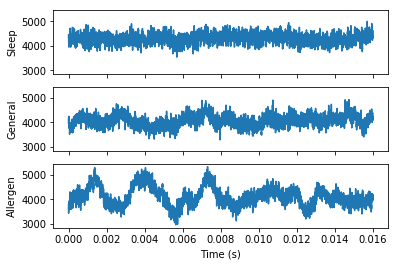

In [4]:
capture_index = 30
fs = 256000
time = [t/fs for t in range(mode2_x.shape[1])]
fig, axes = plt.subplots(3, 1, sharey=True, sharex=True)
axes[2].set_xlabel('Time (s)')
for i, label in enumerate(labels):
    axes[i].plot(time, modes_x[i][capture_index,:])
    axes[i].set_ylabel(label)
fig.show()

### Frequency Domain Information

With this frequency aspect in mind it can be more impactful to differentiate data in the frequency domain. In this case a common technique is to transform sequences or time domain data into image data in the form of spectrograms. This way we can treat the problem as an image classification problem which many ML algorithms are designed to handle.

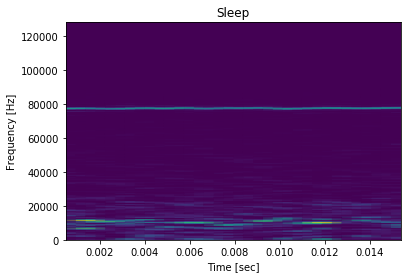

In [5]:
def spec_data(x, fs, plot=False, title=""):
    f, t, Sxx = signal.spectrogram(x, fs, nfft=x.shape[0])
    Sxx = np.abs(Sxx)
    if plot:
        plt.pcolormesh(t, f, Sxx, shading="gouraud")
        plt.ylabel("Frequency [Hz]")
        plt.xlabel("Time [sec]")
        plt.title(title)
        plt.show()
    return Sxx

spec_data(mode2_x[capture_index,:], fs, True, labels[0]);

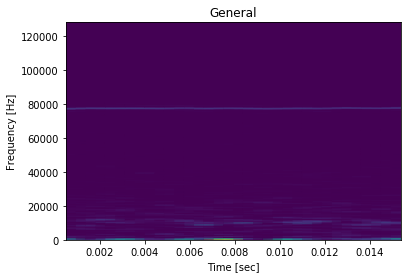

In [6]:
spec_data(mode3_x[capture_index,:], fs, True, labels[1]);

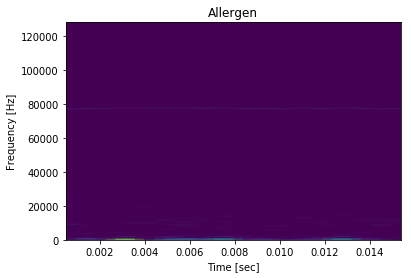

In [7]:
spec_data(mode4_x[capture_index,:], fs, True, labels[2]);

From a simple inspection we can clearly see fading a frequency information across labels, which the network needs to be trained to distinquish.

Next this process will be applied to all data captures and split the data into training and testing sets.

In [8]:
# Apply spectrogram
for i in range(x.shape[0]):
    x_seg = x[i, :]
    sxx = spec_data(x_seg, fs) / x_seg.shape[0]
    sxx = sxx.reshape((1, sxx.shape[0], sxx.shape[1]))
    if i == 0:
        x_sxx = sxx
    else:
        x_sxx = np.vstack((x_sxx, sxx))
x = x_sxx

# Shuffle labeled captures
idx = np.random.permutation(len(y))
x = x[idx]
y = y[idx]

# Split into train and test
train_percent = 0.5
columns = x.shape[0]
train_columns = int(np.floor(train_percent * columns))

x_train = x[:train_columns, :]
y_train = y[:train_columns]
x_test = x[train_columns:, :]
y_test = y[train_columns:]

num_classes = len(np.unique(y))
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# Add a fourth column for input of tensorflow model
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

## CNN and NN Model Implementations

With the training and testing data prepared a model can be constructed to correctly categorize or classify the spectrums into the different labels. Two models have been built for this purpose. One based on using simple neutral nets with just dense layers, and a second using convolutions layers which are very common in image processing.

In [34]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

def create_model_nn(input_shape, n_outputs):

    model = Sequential()
    model.add(Dense(32, activation="relu", input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    # Compile
    model.compile(
        loss=losses.categorical_crossentropy,
        optimizer=optimizers.adam(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model

def create_model_cnn(input_shape, n_outputs):

    model = Sequential()
    model.add(Conv2D(4, kernel_size=(3, 3), activation="relu", input_shape=input_shape))
    model.add(Conv2D(8, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation="softmax"))
    # Compile
    model.compile(
        loss=losses.categorical_crossentropy,
        optimizer=optimizers.adam(learning_rate=0.0004),
        metrics=["accuracy"],
    )
    return model

# Construct models
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
model_nn  = create_model_nn(input_shape, num_classes)
model_cnn = create_model_cnn(input_shape, num_classes)

Both of these models do provide similar classification performance but the CNN is about 150x less parameterize to optimize and will converge much faster than the basic NN.

In [31]:
print(model_nn.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 2049, 18, 32)      64        
_________________________________________________________________
flatten_15 (Flatten)         (None, 1180224)           0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               151068800 
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 3)                 387       
Total params: 151,069,251
Trainable params: 151,069,251
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
print(model_cnn.summary()) 

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 2047, 16, 4)       40        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 2045, 14, 8)       296       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1022, 7, 8)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 1022, 7, 8)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 57232)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                1831456   
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)              

In [35]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

chosen_model = 'cnn'

if chosen_model == 'cnn':
    model = model_cnn
    epochs = 50
else:
    model = model_nn
    epochs = 100

history = model.fit(
    x_train,
    y_train,
    batch_size=8,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
)

Train on 150 samples, validate on 150 samples
Epoch 1/50
150/150 [==============================] - 1s 8ms/step - loss: 1.0973 - accuracy: 0.5000 - val_loss: 1.0942 - val_accuracy: 0.3067
Epoch 2/50
150/150 [==============================] - 1s 7ms/step - loss: 1.0866 - accuracy: 0.4667 - val_loss: 1.0826 - val_accuracy: 0.6200
Epoch 3/50
150/150 [==============================] - 1s 7ms/step - loss: 1.0674 - accuracy: 0.6333 - val_loss: 1.0666 - val_accuracy: 0.5800
Epoch 4/50
150/150 [==============================] - 1s 7ms/step - loss: 1.0296 - accuracy: 0.5267 - val_loss: 1.0273 - val_accuracy: 0.6267
Epoch 5/50
150/150 [==============================] - 1s 7ms/step - loss: 0.9906 - accuracy: 0.6400 - val_loss: 0.9880 - val_accuracy: 0.3800
Epoch 6/50
150/150 [==============================] - 1s 7ms/step - loss: 0.9153 - accuracy: 0.6467 - val_loss: 0.9326 - val_accuracy: 0.6200
Epoch 7/50
150/150 [==============================] - 1s 7ms/step - loss: 0.8448 - accuracy: 0.6667 - 

Studying the results of our model fit and validation, classification of the data sets easily exceeds 95% accuracy with a relatively small number of epochs. This is very attractive for such a simple model.

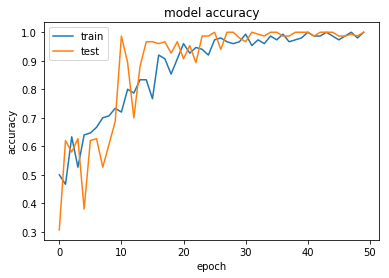

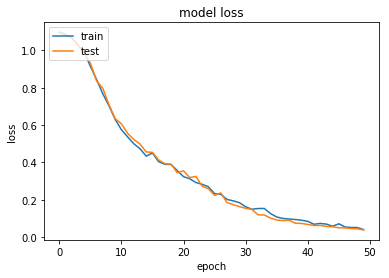

In [36]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()